<center> <h1>Winter is Coming: An Analysis of Sunshine vs Depression</h1> </center>
<center><h3>By Justin Fenn<h3><center>

As someone who regularly battles depression, when the winter arrives and most are thinking of curling up by a fire or the holidays, I am mentally preparing for what I know will be the battle of the year. A theory behind this is that my primitive ancestors from Northern Europe evolved this trait of seasonal "depression" as a way to reduce energy expenditure in the winter in order to survive. Yet, in our modern world of year around productivity, this once useful trait is now a major hindrance. As they say, "Winter is coming".

<center><img src="https://memegenerator.net/img/instances/55313603/brace-yourselves-winter-depression-is-coming.jpg" width="400"/></center>

### Data Wrangling

In order to provide an analysis, I gathered sunshine data from NOAA and health data from the Global Health Data Exchange. I grouped them by state because of the data I could find on mental health data was primarily based on state. 

#### NOAA Sunshine Data
I grouped the <a href="https://www1.ncdc.noaa.gov/pub/data/ccd-data/pctposrank.txt">NOAA sunshine data</a> by state by averaging the different reporting stations in a state. The column 'percent_sunshine' refers to percent sunshine out of the possible sunshine (i.e. how much of the day is sunny on average). This data is an average over a certain amount of years depending on the when weather station was put online.


In [60]:
import requests
import numpy as np
import pandas as pd
import re

url = "https://www1.ncdc.noaa.gov/pub/data/ccd-data/pctposrank.txt"
headers = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'}
html = requests.get(url, headers=headers).text

textLinesRaw = html.splitlines()[7:]

def parseRow(s):
    matches = re.match (".*[,|\s]\s*([\w|\.]+)\s+(\d+)%\s+", s)
    if matches: return [matches.group(1).replace('.',''), int(matches.group(2))]

rows = [parseRow(line) for line in textLinesRaw]
noaa_df = pd.DataFrame(rows, columns=['state', 'percent_sunshine'])
noaa_df = noaa_df.groupby('state').mean().reset_index()
noaa_df.head()

,state,percent_sunshine
0,AK,37.666667
1,AL,57.666667
2,AR,65.000000
3,AZ,84.500000
4,CA,71.857143


#### GBD Health Data
I used data from the Global Health Data Exchange in order to get the depression rates by state. <a href="http://ghdx.healthdata.org/gbd-results-tool?params=gbd-api-2019-permalink/835c901b41d1b53ea2479785f94bbf0b"> Here is a permalink to the data.</a>

In [79]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

gbd_df = pd.read_csv('gbd_depression_data.csv')

# Add abbreviate as state
gbd_df['state'] = gdb_df.apply (lambda row: us_state_abbrev[row['location_name']], axis=1)

#cleanup column names
gbd_df = gbd_df.rename(columns={"val": "depression_rate"})
gbd_df['depression_rate'] = gbd_df['depression_rate'] * 100

# Select Only State, year, and prevalence
gbd_df = gbd_df[['state', 'year', 'depression_rate']]

#Average depression rates over time
gbd_df = gbd_df.groupby('state').mean().reset_index()[['state','depression_rate']]

gbd_df.head()

,state,depression_rate
0,AK,5.331112
1,AL,4.997337
2,AR,5.961617
3,AZ,5.476177
4,CA,4.467830


#### Merged Data
Now we merge the data to get a table of state, depression rate, and sunshine percentage.

In [80]:
merged_df = pd.merge(noaa_df, gbd_df, on=['state'])
merged_df.head()

,state,percent_sunshine,depression_rate
0,AK,37.666667,5.331112
1,AL,57.666667,4.997337
2,AR,65.000000,5.961617
3,AZ,84.500000,5.476177
4,CA,71.857143,4.467830


### Data Analysis and Visualization

Now that we have the data that we want, we should visualize the data and see if we can see a pattern. To do this, we can make a scatter plot showing the relationship between sunshine percentage and depression rates in each state.

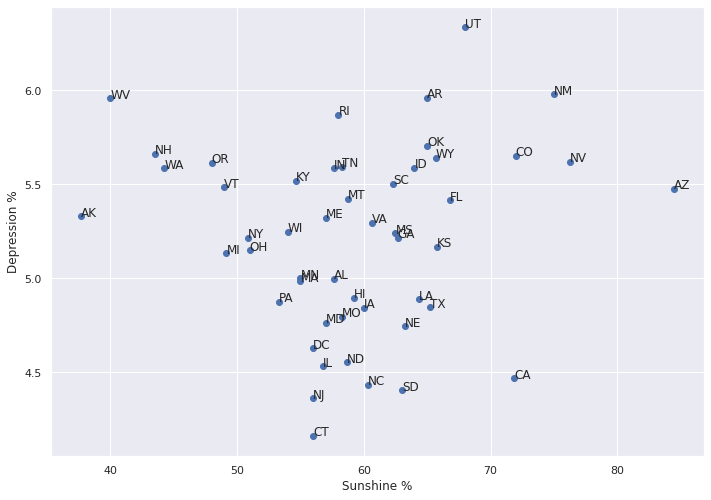

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})

x = merged_df['percent_sunshine']
y = merged_df['depression_rate']

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_xlabel('Sunshine %')
ax.set_ylabel('Depression %')

for i, txt in enumerate(merged_df['state']):
    ax.annotate(txt, (x.iloc[i], y.iloc[i]))

From our scatter plot, it seems like states with a higher depression rate also have a more extreme sunshine percentage (either very high or very low). To further show this, let's group the states by depression rate into 6 bins and show a violin plot of each bin.

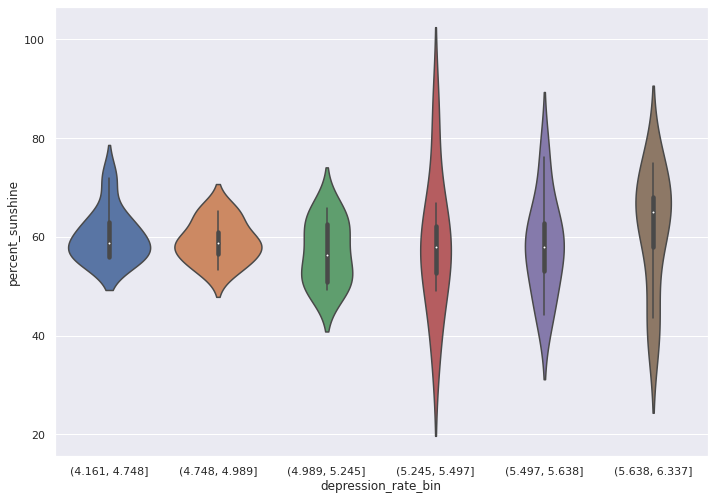

In [94]:
merged_df['depression_rate_bin'] = pd.qcut(merged_df['depression_rate'], q=6)

p = sns.violinplot(data=merged_df, x = 'depression_rate_bin', y='percent_sunshine')


As can be seen in this violin plot, when there is a higher variance of sunshine percentage (i.e. extreme highs and lows) the state is more likely to have a higher depression rate.

Another way to visualize this data is to take the difference between the percent_sunshine and the mean of percent_sunshine. This way we can see the relationship of living in more extreme sunshine percentage a bit clearer. 

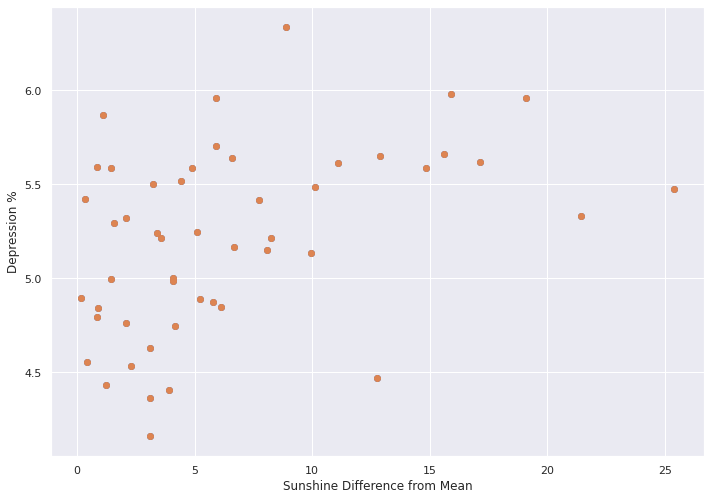

In [135]:
mean_sunshine = merged_df['percent_sunshine'].mean()

merged_df['sunshine_diff_from_mean'] = abs(merged_df['percent_sunshine'] - mean_sunshine)#merged_df.apply (lambda row: row['location_name'], axis=1)

fig, ax = plt.subplots()
ax.scatter(x, y)

x = merged_df['sunshine_diff_from_mean'].values.reshape(-1,1)
y = merged_df['depression_rate'].values.reshape(-1,1)

ax.set_xlabel('Sunshine Difference from Mean')
ax.set_ylabel('Depression %')

plt.scatter(x,y)

## Conclusion

My hypothesis that there is a linear correlation between sunshine and depression rates did not hold true, but from this analysis there was an insight. It seems that the old adage of "All good things in moderation" seems to apply to sunshine as well. An average amount of sunshine does not correlate to a high or low rate of depression, but a very low or very high amount of sunshine does seem to correlate to a high incidence of depression in a state.

In a future analysis, I would like to take more granular data of sunshine and mental health data since a state can be large and have many different sunshine percentages and depression rates across it. Unfortunately, for the scope of this analysis the datasets required for this analysis would have needed much more data tidying.

In conclusion, if you struggle with depression, you may have better luck in a more moderately sunny state or the one outlier: California, where the rate of depression is relatively low but its much more sunny on average than most states.